In [51]:
# Import all required libraries
import warnings
import pathlib
import sys

# Add src directory to path for helper functions
repo_dir = pathlib.Path().cwd().parent
src_dir = repo_dir / "src"
sys.path.insert(0, str(src_dir))

# Data manipulation and scientific computing
import pandas as pd
import numpy as np
import scipy.sparse

# Machine learning and neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Progress bars and utilities
from tqdm import tqdm

# Domain-specific libraries
import hetmatpy.matrix

# Import helper functions from src package
from models import EdgePredictionNN
from data_processing import prepare_edge_prediction_data, load_permutation_data, load_all_permutations
from training import train_edge_prediction_model, train_across_permutations
from visualization import (
    plot_training_history, 
    evaluate_model_performance, 
    create_probability_heatmap,
    plot_permutation_comparison
)

In [54]:
# Parameters for papermill
# Default parameter values - can be overridden by papermill
permutations_subdirectory = "permutations"  # Default: use 'permutations' (local generated)
                                           # Example alternatives: 'hetio200' (downloaded), 'permutations/hetio200'

# Validation
if not isinstance(permutations_subdirectory, str):
    raise ValueError(f"permutations_subdirectory must be a string, got: {permutations_subdirectory}")

print(f"Using permutations subdirectory: {permutations_subdirectory}")

Using permutations subdirectory: permutations


In [55]:
# Set up paths for data access using parameterized directory
repo_dir = pathlib.Path().cwd().parent
data_dir = repo_dir / 'data'

# Use the parameterized permutations subdirectory
if '/' in permutations_subdirectory:
    # Handle nested paths like 'permutations/hetio200'
    permutations_dir = data_dir / permutations_subdirectory
elif permutations_subdirectory == 'permutations':
    # Handle the default case where we want data/permutations
    permutations_dir = data_dir / 'permutations'
else:
    # Handle other subdirectories like 'hetio200' -> data/permutations/hetio200
    permutations_dir = data_dir / 'permutations' / permutations_subdirectory

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")

# List available permutations
if permutations_dir.exists():
    available_permutations = [p.name for p in permutations_dir.iterdir() if p.is_dir()]
    print(f"Available permutations: {available_permutations}")
else:
    print(f"⚠️ Permutations directory not found: {permutations_dir}")
    available_permutations = []

Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn
Data directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data
Permutations directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations
Available permutations: ['000.hetmat.bak', '001.hetmat', '000.hetmat']


In [ ]:
# Load and combine data from all available permutations
if available_permutations:
    print("Loading all available permutations...")
    all_perm_data = load_all_permutations(available_permutations, permutations_dir)
    print(f"\nSuccessfully loaded {len(all_perm_data)} permutations: {list(all_perm_data.keys())}")
    
    if not all_perm_data:
        raise ValueError("No permutations were successfully loaded!")
    
    # Combine AeG matrices from all permutations
    print("\n" + "="*60)
    print("COMBINING AeG MATRICES FROM ALL PERMUTATIONS")
    print("="*60)
    
    combined_aeg_edges = []
    combined_anatomy_nodes = None
    combined_gene_nodes = None
    permutation_labels = []
    
    for perm_name, perm_data in all_perm_data.items():
        aeg_edges = perm_data['aeg_edges']
        anatomy_nodes = perm_data['anatomy_nodes']
        gene_nodes = perm_data['gene_nodes']
        
        print(f"Processing {perm_name}: {aeg_edges.shape} matrix with {aeg_edges.nnz} edges")
        
        # Store the AeG matrix
        combined_aeg_edges.append(aeg_edges)
        
        # Use node information from first permutation (should be consistent across permutations)
        if combined_anatomy_nodes is None:
            combined_anatomy_nodes = anatomy_nodes
            combined_gene_nodes = gene_nodes
            print(f"Using node definitions from {perm_name}")
            print(f"  Anatomy nodes: {len(anatomy_nodes)}")
            print(f"  Gene nodes: {len(gene_nodes)}")
        
        # Track which permutation each edge comes from
        permutation_labels.extend([perm_name] * aeg_edges.nnz)
    
    print(f"\nCombined data summary:")
    print(f"  Total permutations: {len(combined_aeg_edges)}")
    print(f"  Total edges across all permutations: {len(permutation_labels)}")
    print(f"  Matrix dimensions: {combined_aeg_edges[0].shape}")
    
    # Store combined data for neural network training
    print(f"\nData successfully combined from {len(all_perm_data)} permutations")
    
else:
    print("No permutations found in the permutations directory!")

Loading example data from: 000.hetmat
Loading data from permutation: 000.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']

DATA SUMMARY
AeG edges matrix shape: (402, 20945)
AeG edges density: 0.062519
Number of Anatomy nodes: 402
Number of Gene nodes: 20945

Sample Anatomy nodes:
   position      identifier                       name
0         0  UBERON:0000002             uterine cervix
1         1  UBERON:0000004                       nose
2         2  UBERON:0000006        islet of Langerhans
3         3  UBERON:0000007            pituitary gland
4         4  UBERON:0000010  peripheral nervous system

Sample Gene nodes:
   position  identifier      name
0

In [56]:
# Verify all libraries are available for neural network training
print("All required libraries successfully imported!")
print("Ready for combined permutation analysis and neural network training.")

All required libraries successfully imported!
Ready for combined permutation analysis and neural network training.


In [57]:
# Prepare combined training data from all permutations
print("="*60)
print("PREPARING COMBINED TRAINING DATA")
print("="*60)

# Combine features and labels from all permutations
all_features = []
all_labels = []
permutation_sources = []

for perm_name, perm_data in all_perm_data.items():
    print(f"\nProcessing permutation: {perm_name}")
    
    # Prepare edge prediction data for this permutation
    features, labels = prepare_edge_prediction_data(
        perm_data, 
        sample_negative_ratio=1.0
    )
    
    print(f"  Features shape: {features.shape}")
    print(f"  Positive examples: {np.sum(labels == 1)}")
    print(f"  Negative examples: {np.sum(labels == 0)}")
    
    # Add to combined dataset
    all_features.append(features)
    all_labels.append(labels)
    
    # Track which permutation each sample comes from
    permutation_sources.extend([perm_name] * len(labels))

# Combine all features and labels
combined_features = np.vstack(all_features)
combined_labels = np.concatenate(all_labels)

print(f"\n" + "="*60)
print("COMBINED DATASET SUMMARY")
print("="*60)
print(f"Total samples: {len(combined_labels)}")
print(f"Total positive examples: {np.sum(combined_labels == 1)}")
print(f"Total negative examples: {np.sum(combined_labels == 0)}")
print(f"Feature matrix shape: {combined_features.shape}")
print(f"Data from {len(all_perm_data)} permutations: {list(all_perm_data.keys())}")

# Analyze degree ranges across all permutations
print(f"\nDegree statistics across all permutations:")
print(f"Source degree range: {combined_features[:, 0].min():.1f} - {combined_features[:, 0].max():.1f}")
print(f"Target degree range: {combined_features[:, 1].min():.1f} - {combined_features[:, 1].max():.1f}")
print(f"Source degree mean: {combined_features[:, 0].mean():.2f} ± {combined_features[:, 0].std():.2f}")
print(f"Target degree mean: {combined_features[:, 1].mean():.2f} ± {combined_features[:, 1].std():.2f}")

PREPARING COMBINED TRAINING DATA

Processing permutation: 000.hetmat
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
  Features shape: (1052814, 2)
  Positive examples: 526407
  Negative examples: 526407

Processing permutation: 001.hetmat
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of negative examples (non-existing edges): 526407
  Features shape: (1052814, 2)
  Positive examples: 526407
  Negative examples: 526407

Processing permutation: 001.hetmat
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
  Features shape: (1052814, 2)
  Positive examples: 526407
  Negative examples: 526407

COMBINED DATASET SUMMARY
Total samples: 


TRAINING NEURAL NETWORK ON COMBINED DATASET
Training neural network on combined permutation data...
Training on 1684502 samples, testing on 421126 samples
Feature shapes: (1684502, 2), Labels shape: (1684502,)
Training on 1684502 samples, testing on 421126 samples
Feature shapes: (1684502, 2), Labels shape: (1684502,)


Training:  67%|██████▋   | 20/30 [02:32<01:16,  7.63s/it]

Epoch 20/30: Train Loss: 0.1303, Val Loss: 0.1294, Val AUC: 0.9876


Training: 100%|██████████| 30/30 [03:49<00:00,  7.65s/it]



Final Test AUC: 0.9877
Final Test AP: 0.9848

Training completed!
Final Test AUC: 0.9877
Final Test Average Precision: 0.9848

Plotting training history...


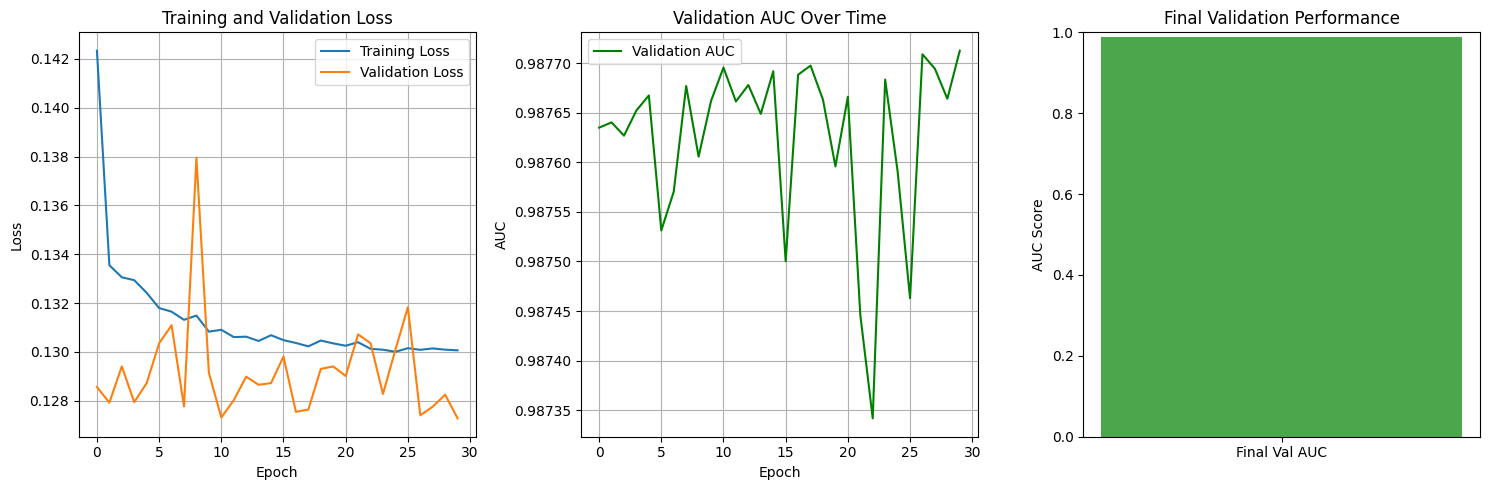


Evaluating model performance...
Test AUC: 0.9877
Average Precision: 0.9848


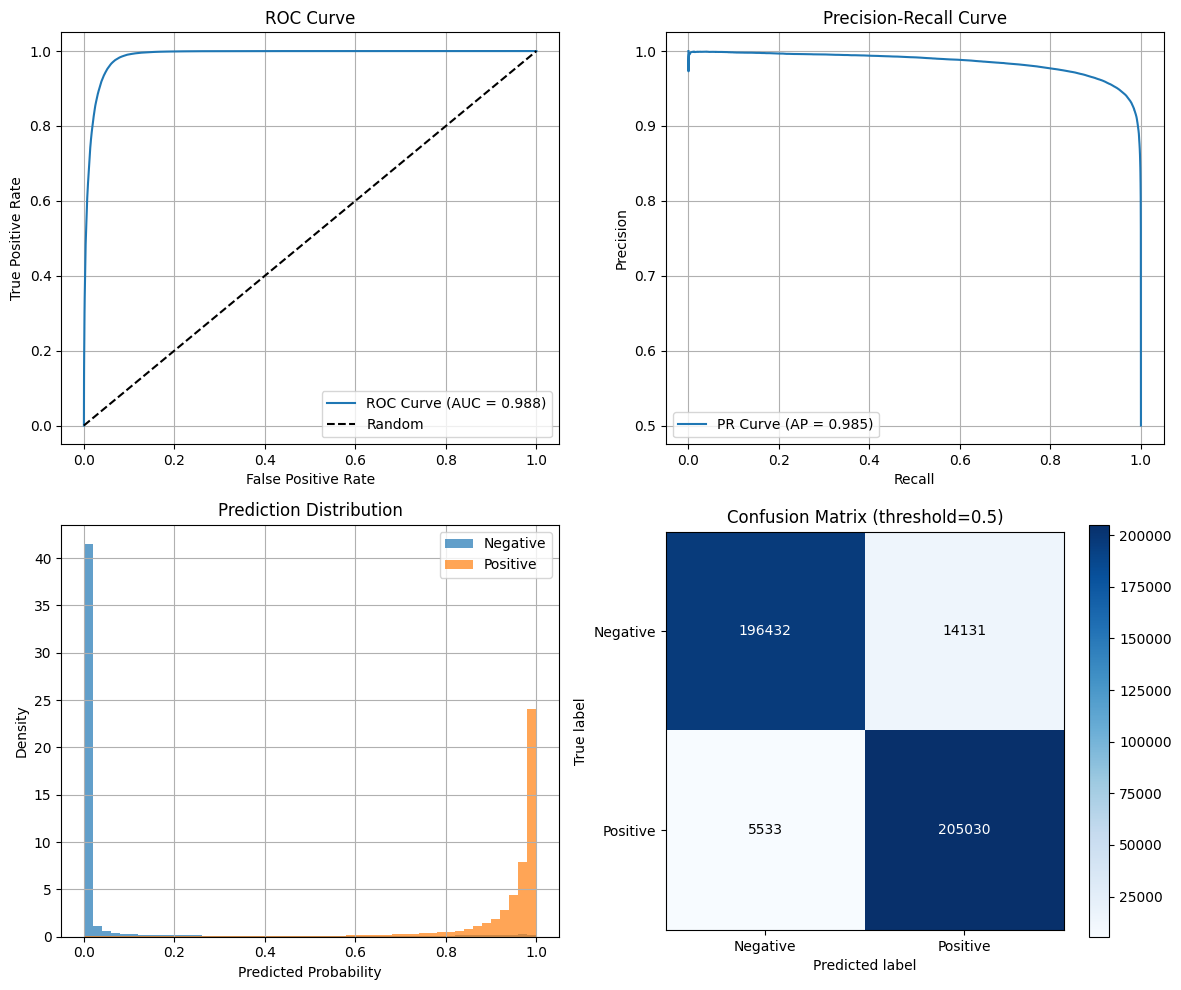

In [59]:
# Train neural network on combined dataset
print("\n" + "="*60)
print("TRAINING NEURAL NETWORK ON COMBINED DATASET")
print("="*60)

# Train the model on combined data
print("Training neural network on combined permutation data...")
model, train_history, test_metrics = train_edge_prediction_model(
    combined_features, combined_labels, 
    epochs=30,  # More epochs for larger, more complex dataset
    batch_size=1024,  # Larger batch size for combined data
    learning_rate=0.001
)

print(f"\nTraining completed!")
print(f"Final Test AUC: {test_metrics['auc']:.4f}")
print(f"Final Test Average Precision: {test_metrics['average_precision']:.4f}")

# Visualize training results
print("\nPlotting training history...")
plot_training_history(train_history)

print("\nEvaluating model performance...")
threshold_results = evaluate_model_performance(test_metrics)


PROBABILITY HEATMAP ANALYSIS
Creating probability heatmap...
Source degree range: 0.0 - 15036.0
Target degree range: 0.0 - 98.0


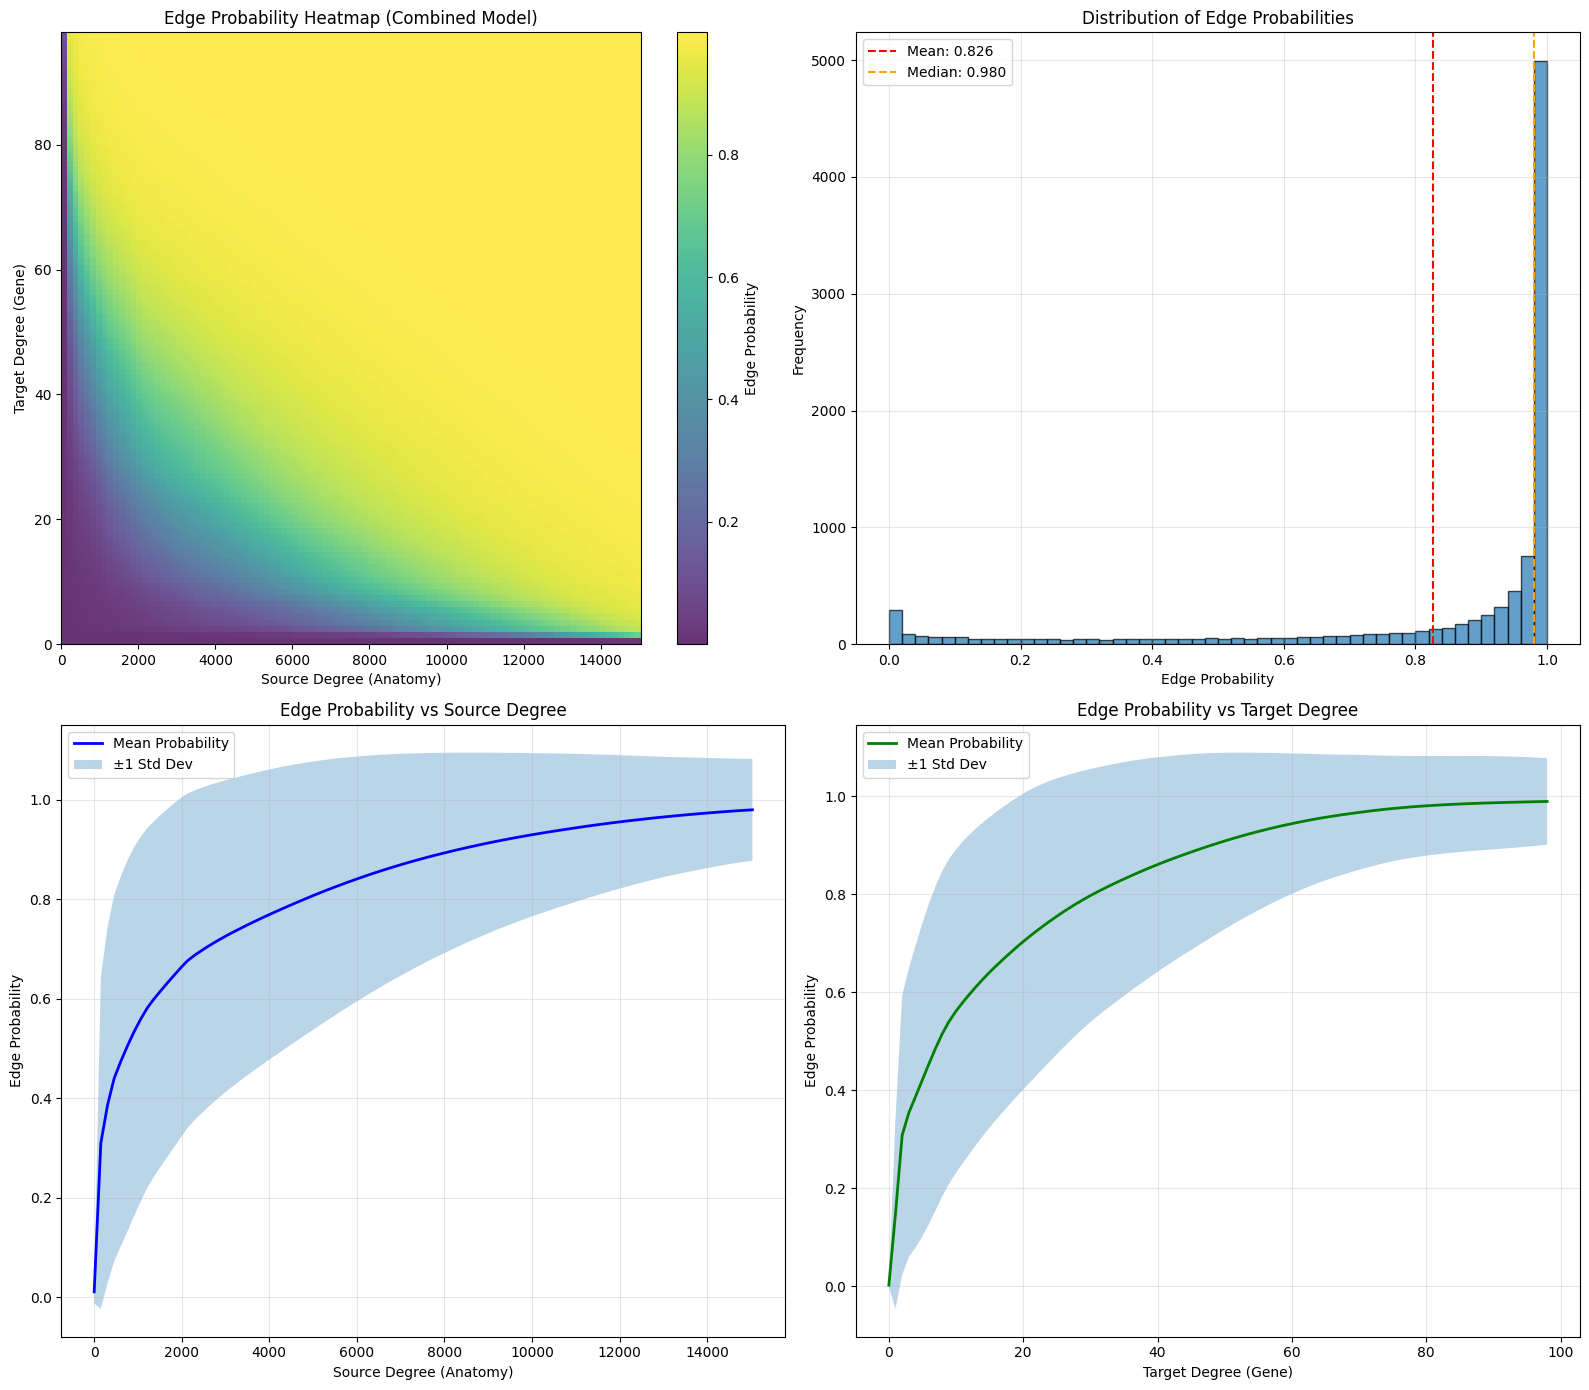


Summary Statistics:
Overall probability range: 0.0000 - 1.0000
Mean probability: 0.8262 ± 0.2888
Median probability: 0.9798

High probability regions (>95th percentile, >1.000):
  Source degree: 15036.0, Target degree: 70.3, Probability: 0.9999
  Source degree: 14884.1, Target degree: 71.3, Probability: 0.9999
  Source degree: 15036.0, Target degree: 71.3, Probability: 0.9999
  Source degree: 14732.2, Target degree: 72.3, Probability: 0.9999
  Source degree: 14884.1, Target degree: 72.3, Probability: 0.9999

Low probability regions (<5th percentile, <0.073):
  Source degree: 0.0, Target degree: 0.0, Probability: 0.0000
  Source degree: 151.9, Target degree: 0.0, Probability: 0.0000
  Source degree: 303.8, Target degree: 0.0, Probability: 0.0000
  Source degree: 455.6, Target degree: 0.0, Probability: 0.0000
  Source degree: 607.5, Target degree: 0.0, Probability: 0.0000


In [61]:
# Create probability heatmap for combined model
print("\n" + "="*60)
print("PROBABILITY HEATMAP ANALYSIS")
print("="*60)

# Use the scaler from the trained model
scaler = test_metrics['scaler']

# Determine degree ranges from combined data
source_degrees = np.linspace(
    combined_features[:, 0].min(), 
    combined_features[:, 0].max(), 
    100
)
target_degrees = np.linspace(
    combined_features[:, 1].min(), 
    combined_features[:, 1].max(), 
    100
)

print(f"Creating probability heatmap...")
print(f"Source degree range: {source_degrees.min():.1f} - {source_degrees.max():.1f}")
print(f"Target degree range: {target_degrees.min():.1f} - {target_degrees.max():.1f}")

# Create probability heatmap - unpack the returned tuple properly
probability_matrix, _, _ = create_probability_heatmap(
    model, scaler, source_degrees, target_degrees, resolution=100
)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Main probability heatmap
im1 = axes[0, 0].imshow(probability_matrix, 
                       extent=[source_degrees.min(), source_degrees.max(), 
                              target_degrees.min(), target_degrees.max()],
                       origin='lower', aspect='auto', cmap='viridis', alpha=0.8)

axes[0, 0].set_xlabel('Source Degree (Anatomy)')
axes[0, 0].set_ylabel('Target Degree (Gene)')
axes[0, 0].set_title('Edge Probability Heatmap (Combined Model)')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Edge Probability')

# 2. Probability distribution histogram
axes[0, 1].hist(probability_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Edge Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Edge Probabilities')
axes[0, 1].grid(True, alpha=0.3)

# Add summary statistics
mean_prob = probability_matrix.mean()
median_prob = np.median(probability_matrix)
axes[0, 1].axvline(mean_prob, color='red', linestyle='--', label=f'Mean: {mean_prob:.3f}')
axes[0, 1].axvline(median_prob, color='orange', linestyle='--', label=f'Median: {median_prob:.3f}')
axes[0, 1].legend()

# 3. Probability vs Source Degree (averaged over target degrees)
mean_prob_by_source = probability_matrix.mean(axis=0)
std_prob_by_source = probability_matrix.std(axis=0)
axes[1, 0].plot(source_degrees, mean_prob_by_source, 'b-', linewidth=2, label='Mean Probability')
axes[1, 0].fill_between(source_degrees, 
                       mean_prob_by_source - std_prob_by_source,
                       mean_prob_by_source + std_prob_by_source, 
                       alpha=0.3, label='±1 Std Dev')
axes[1, 0].set_xlabel('Source Degree (Anatomy)')
axes[1, 0].set_ylabel('Edge Probability')
axes[1, 0].set_title('Edge Probability vs Source Degree')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Probability vs Target Degree (averaged over source degrees)
mean_prob_by_target = probability_matrix.mean(axis=1)
std_prob_by_target = probability_matrix.std(axis=1)
axes[1, 1].plot(target_degrees, mean_prob_by_target, 'g-', linewidth=2, label='Mean Probability')
axes[1, 1].fill_between(target_degrees, 
                       mean_prob_by_target - std_prob_by_target,
                       mean_prob_by_target + std_prob_by_target, 
                       alpha=0.3, label='±1 Std Dev')
axes[1, 1].set_xlabel('Target Degree (Gene)')
axes[1, 1].set_ylabel('Edge Probability')
axes[1, 1].set_title('Edge Probability vs Target Degree')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Overall probability range: {probability_matrix.min():.4f} - {probability_matrix.max():.4f}")
print(f"Mean probability: {probability_matrix.mean():.4f} ± {probability_matrix.std():.4f}")
print(f"Median probability: {np.median(probability_matrix):.4f}")

# Analyze high and low probability regions
high_prob_threshold = np.percentile(probability_matrix, 95)
low_prob_threshold = np.percentile(probability_matrix, 5)

print(f"\nHigh probability regions (>95th percentile, >{high_prob_threshold:.3f}):")
high_prob_mask = probability_matrix > high_prob_threshold
high_prob_indices = np.where(high_prob_mask)
if len(high_prob_indices[0]) > 0:
    for i in range(min(5, len(high_prob_indices[0]))):
        source_idx, target_idx = high_prob_indices[1][i], high_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

print(f"\nLow probability regions (<5th percentile, <{low_prob_threshold:.3f}):")
low_prob_mask = probability_matrix < low_prob_threshold
low_prob_indices = np.where(low_prob_mask)
if len(low_prob_indices[0]) > 0:
    for i in range(min(5, len(low_prob_indices[0]))):
        source_idx, target_idx = low_prob_indices[1][i], low_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")


LOGISTIC REGRESSION BASELINE COMPARISON
Training logistic regression model...

Logistic Regression Results:
Train AUC: 0.9781
Test AUC: 0.9780
Train AP: 0.9751
Test AP: 0.9748

Neural Network Results (for comparison):
Test AUC: 0.9877
Test AP: 0.9848

Performance Difference (NN - LR):
AUC improvement: +0.0097 (+1.0%)
AP improvement: +0.0100 (+1.0%)


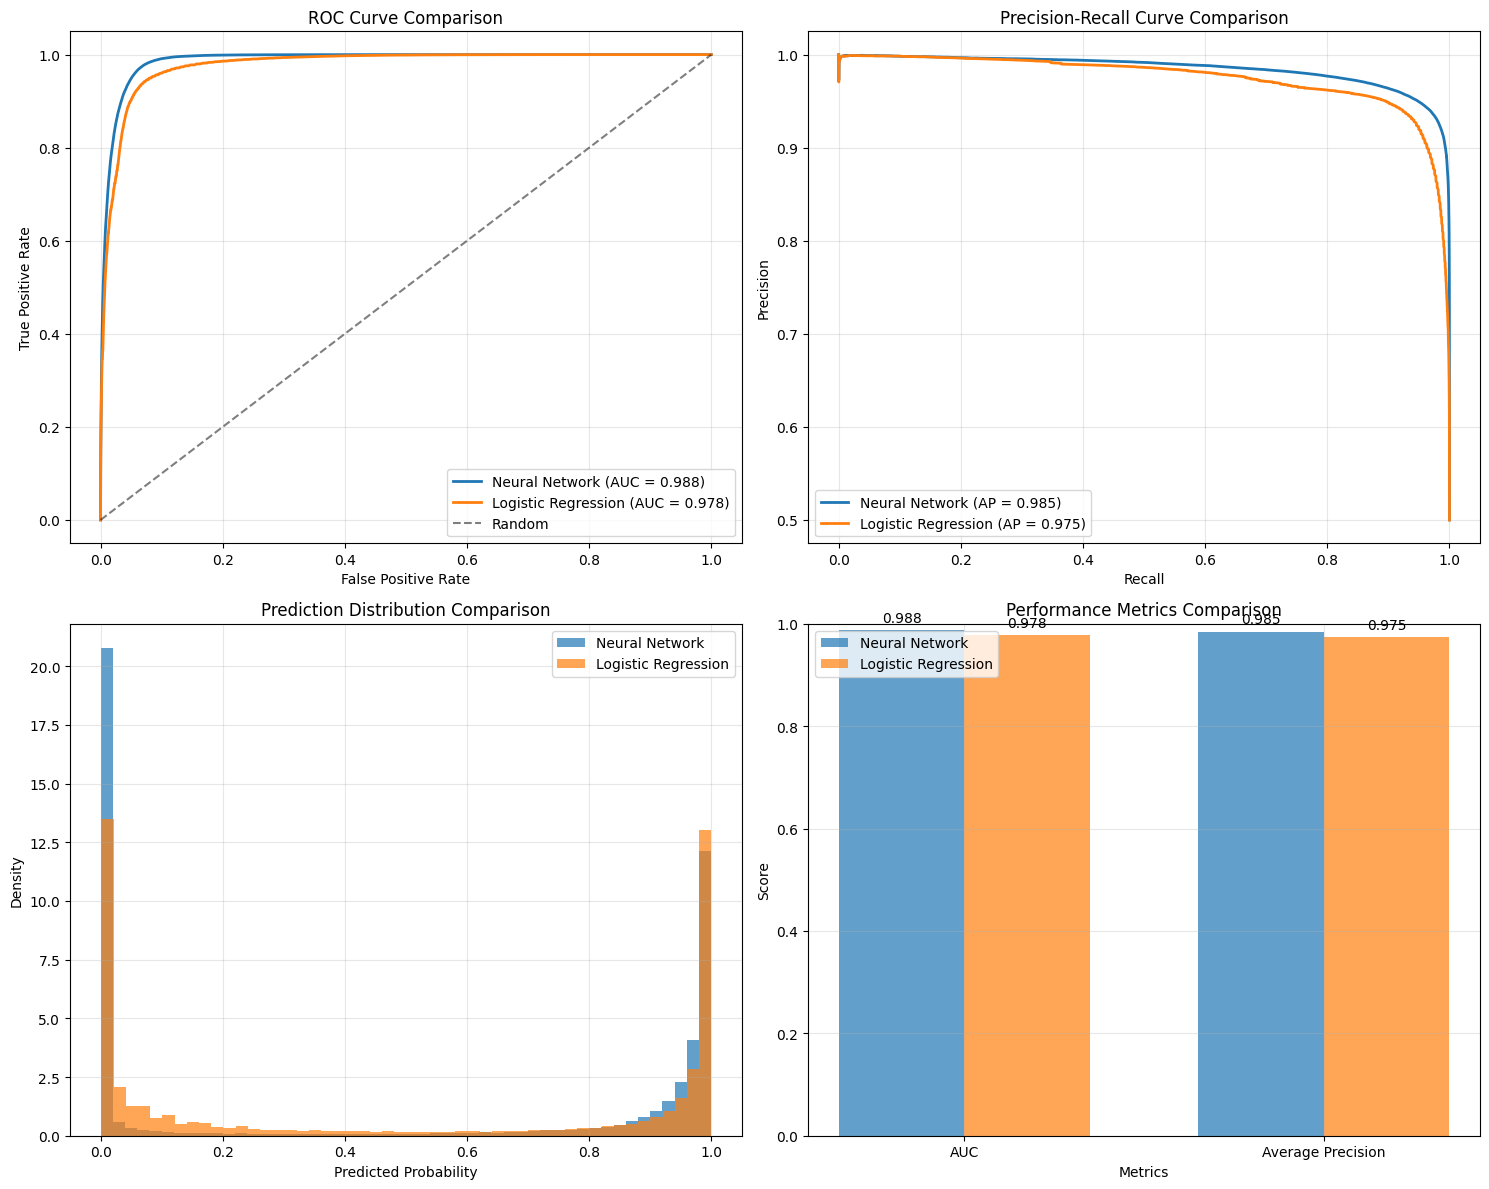


Logistic Regression Coefficients:
Source degree coefficient: 3.8311
Target degree coefficient: 1.9010
Intercept: 0.1400
→ Higher source degree increases edge probability
→ Higher target degree increases edge probability

🔄 Neural Network and Logistic Regression perform similarly
   The relationship appears to be primarily linear


In [62]:
# Compare with simple logistic regression baseline
print("\n" + "="*60)
print("LOGISTIC REGRESSION BASELINE COMPARISON")
print("="*60)

# Use the same train/test split as the neural network
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, combined_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=combined_labels
)

# Scale features for logistic regression (use same scaler as NN)
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

print("Training logistic regression model...")

# Train logistic regression with regularization
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0  # Regularization strength
)
lr_model.fit(X_train_scaled, y_train)

# Get predictions
lr_train_pred = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_pred = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
lr_train_auc = roc_auc_score(y_train, lr_train_pred)
lr_test_auc = roc_auc_score(y_test, lr_test_pred)
lr_train_ap = average_precision_score(y_train, lr_train_pred)
lr_test_ap = average_precision_score(y_test, lr_test_pred)

print(f"\nLogistic Regression Results:")
print(f"Train AUC: {lr_train_auc:.4f}")
print(f"Test AUC: {lr_test_auc:.4f}")
print(f"Train AP: {lr_train_ap:.4f}")
print(f"Test AP: {lr_test_ap:.4f}")

print(f"\nNeural Network Results (for comparison):")
print(f"Test AUC: {test_metrics['auc']:.4f}")
print(f"Test AP: {test_metrics['average_precision']:.4f}")

# Calculate performance differences
auc_diff = test_metrics['auc'] - lr_test_auc
ap_diff = test_metrics['average_precision'] - lr_test_ap

print(f"\nPerformance Difference (NN - LR):")
print(f"AUC improvement: {auc_diff:+.4f} ({auc_diff/lr_test_auc*100:+.1f}%)")
print(f"AP improvement: {ap_diff:+.4f} ({ap_diff/lr_test_ap*100:+.1f}%)")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curves comparison
nn_fpr, nn_tpr, _ = roc_curve(test_metrics['true_labels'], test_metrics['predictions'])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_pred)

axes[0, 0].plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {test_metrics["auc"]:.3f})', linewidth=2)
axes[0, 0].plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_test_auc:.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curves comparison
nn_precision, nn_recall, _ = precision_recall_curve(test_metrics['true_labels'], test_metrics['predictions'])
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_test_pred)

axes[0, 1].plot(nn_recall, nn_precision, label=f'Neural Network (AP = {test_metrics["average_precision"]:.3f})', linewidth=2)
axes[0, 1].plot(lr_recall, lr_precision, label=f'Logistic Regression (AP = {lr_test_ap:.3f})', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prediction distribution comparison
axes[1, 0].hist(test_metrics['predictions'], bins=50, alpha=0.7, label='Neural Network', density=True)
axes[1, 0].hist(lr_test_pred, bins=50, alpha=0.7, label='Logistic Regression', density=True)
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Prediction Distribution Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Performance metrics bar chart
metrics = ['AUC', 'Average Precision']
nn_scores = [test_metrics['auc'], test_metrics['average_precision']]
lr_scores = [lr_test_auc, lr_test_ap]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, nn_scores, width, label='Neural Network', alpha=0.7)
axes[1, 1].bar(x + width/2, lr_scores, width, label='Logistic Regression', alpha=0.7)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Performance Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

# Add value labels on bars
for i, (nn_score, lr_score) in enumerate(zip(nn_scores, lr_scores)):
    axes[1, 1].text(i - width/2, nn_score + 0.01, f'{nn_score:.3f}', ha='center', va='bottom')
    axes[1, 1].text(i + width/2, lr_score + 0.01, f'{lr_score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Analyze logistic regression coefficients
print(f"\nLogistic Regression Coefficients:")
print(f"Source degree coefficient: {lr_model.coef_[0][0]:.4f}")
print(f"Target degree coefficient: {lr_model.coef_[0][1]:.4f}")
print(f"Intercept: {lr_model.intercept_[0]:.4f}")

# Interpretation
if lr_model.coef_[0][0] > 0:
    print(f"→ Higher source degree increases edge probability")
else:
    print(f"→ Higher source degree decreases edge probability")

if lr_model.coef_[0][1] > 0:
    print(f"→ Higher target degree increases edge probability")
else:
    print(f"→ Higher target degree decreases edge probability")

# Statistical significance test (if the difference is meaningful)
if abs(auc_diff) > 0.01:  # Threshold for meaningful difference
    if auc_diff > 0:
        print(f"\n✅ Neural Network shows meaningful improvement over Logistic Regression")
        print(f"   The non-linear model captures patterns that linear regression misses")
    else:
        print(f"\n⚠️ Logistic Regression performs similarly or better than Neural Network")
        print(f"   The relationship might be primarily linear")
else:
    print(f"\n🔄 Neural Network and Logistic Regression perform similarly")
    print(f"   The relationship appears to be primarily linear")


COMPREHENSIVE MODEL COMPARISON
Training multiple baseline models...

1. Training Linear Logistic Regression...
Training multiple baseline models...

1. Training Linear Logistic Regression...
2. Training Polynomial Logistic Regression (degree 2)...
2. Training Polynomial Logistic Regression (degree 2)...
3. Training Random Forest...
3. Training Random Forest...

MODEL PERFORMANCE COMPARISON
Model                AUC        AP         AUC vs NN    AP vs NN    
-----------------------------------------------------------------
Linear LR            0.9780    0.9748    -0.0097       -0.0100
Polynomial LR        0.9844    0.9819    -0.0033       -0.0029
Random Forest        0.9877    0.9848    +0.0000       -0.0001
Neural Network       0.9877    0.9848    +0.0000       +0.0000

MODEL PERFORMANCE COMPARISON
Model                AUC        AP         AUC vs NN    AP vs NN    
-----------------------------------------------------------------
Linear LR            0.9780    0.9748    -0.0097      

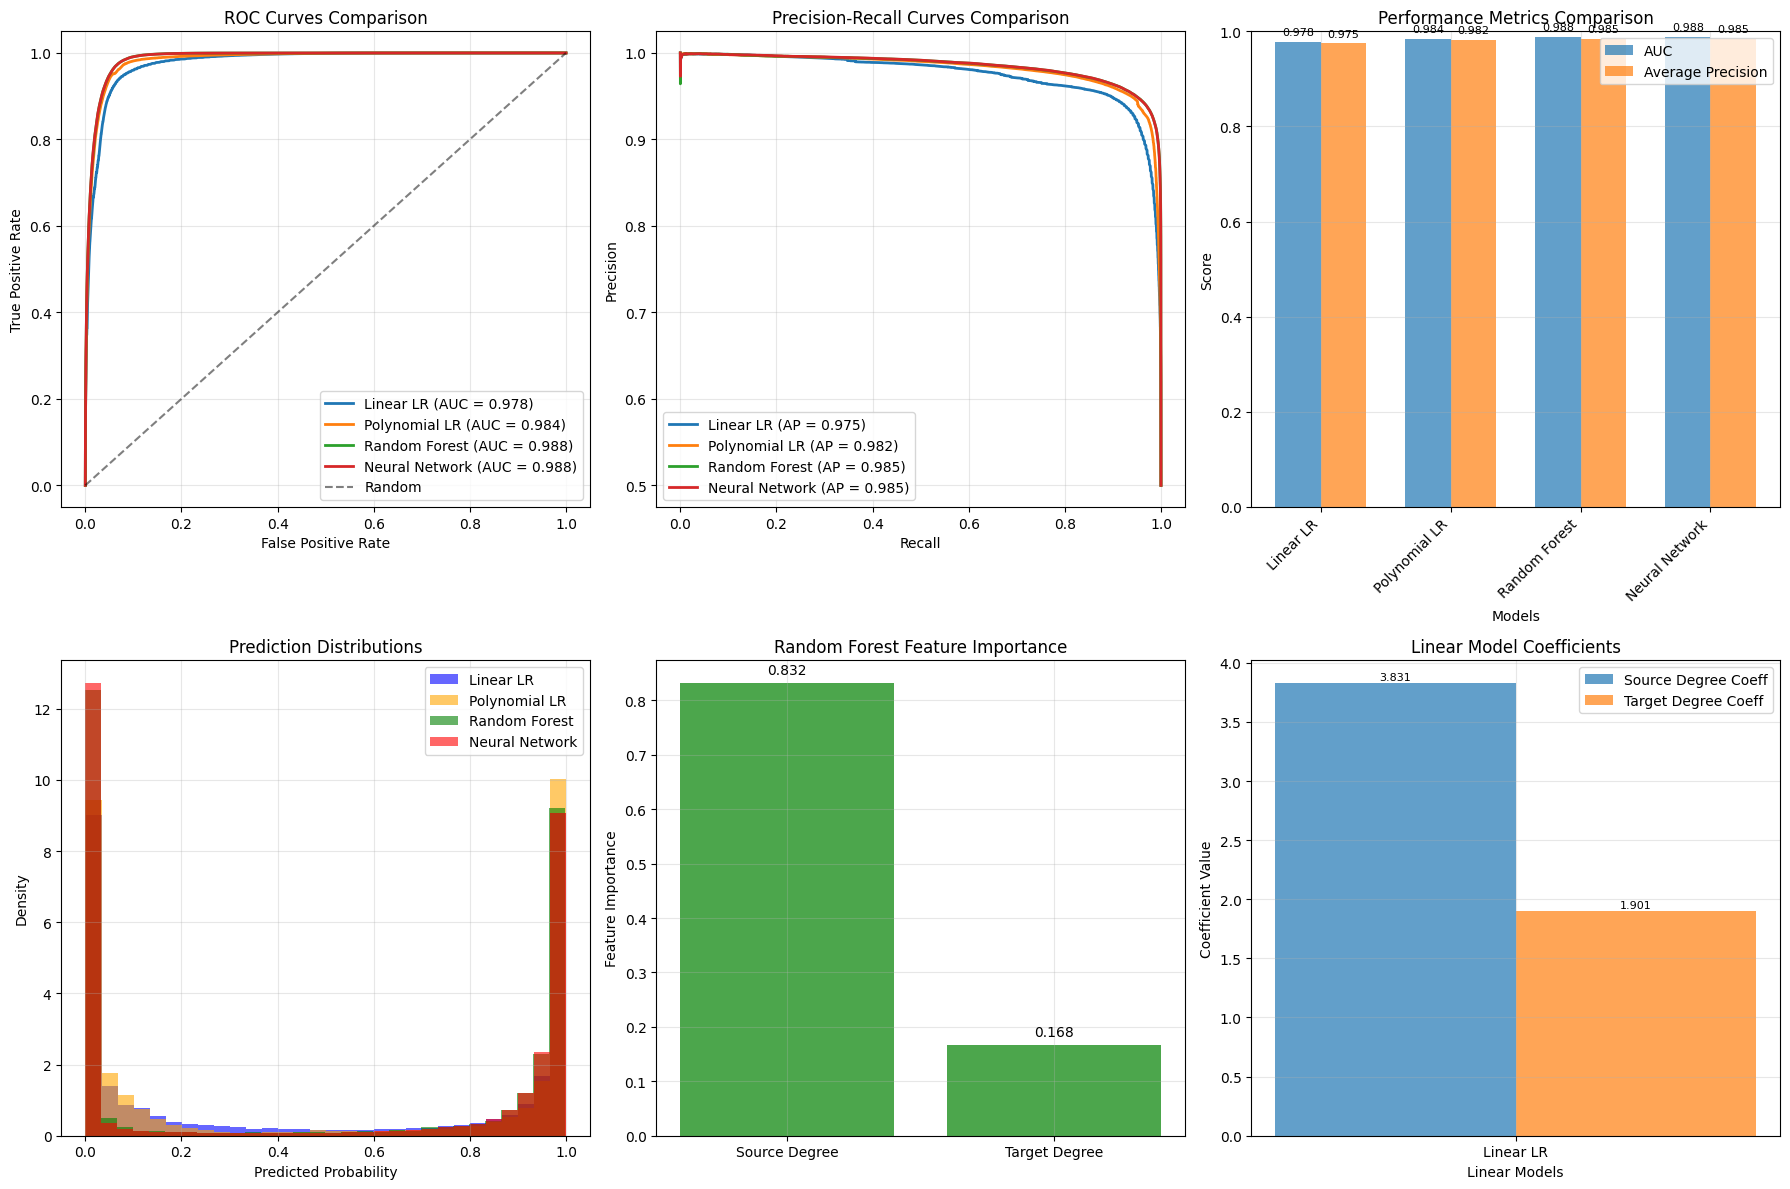


DETAILED ANALYSIS
Best AUC: Random Forest (0.9877)
Best AP: Neural Network (0.9848)

Performance improvements over Linear Logistic Regression:
Polynomial LR:
  AUC: +0.0065 (+0.7%)
  AP:  +0.0071 (+0.7%)
Random Forest:
  AUC: +0.0097 (+1.0%)
  AP:  +0.0099 (+1.0%)
Neural Network:
  AUC: +0.0097 (+1.0%)
  AP:  +0.0100 (+1.0%)

Model Complexity vs Performance Analysis:
Linear LR:     Simple, fast, interpretable
Polynomial LR: Moderate complexity, captures interactions
Random Forest: High complexity, handles non-linearity, interpretable
Neural Network: Highest complexity, most flexible

RECOMMENDATIONS
🌲 RANDOM FOREST RECOMMENDED
   - Better performance than neural network
   - More interpretable feature importance
   - Good balance of complexity and performance

Note: Performance differences < 0.010 AUC may not be practically significant.
Consider model complexity, interpretability, and computational requirements.


In [63]:
# Comprehensive model comparison: Neural Network vs Multiple Baselines
print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Use the same train/test split for all models
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, combined_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=combined_labels
)

# Scale features for all models
scaler_comp = StandardScaler()
X_train_scaled = scaler_comp.fit_transform(X_train)
X_test_scaled = scaler_comp.transform(X_test)

# Store results for comparison
model_results = {}

print("Training multiple baseline models...")

# 1. Simple Logistic Regression
print("\n1. Training Linear Logistic Regression...")
lr_simple = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
lr_simple.fit(X_train_scaled, y_train)
lr_simple_pred = lr_simple.predict_proba(X_test_scaled)[:, 1]

model_results['Linear LR'] = {
    'predictions': lr_simple_pred,
    'auc': roc_auc_score(y_test, lr_simple_pred),
    'ap': average_precision_score(y_test, lr_simple_pred),
    'model': lr_simple
}

# 2. Polynomial Logistic Regression (degree 2)
print("2. Training Polynomial Logistic Regression (degree 2)...")
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

lr_poly = LogisticRegression(random_state=42, max_iter=2000, C=0.1)  # More regularization for polynomial
lr_poly.fit(X_train_poly, y_train)
lr_poly_pred = lr_poly.predict_proba(X_test_poly)[:, 1]

model_results['Polynomial LR'] = {
    'predictions': lr_poly_pred,
    'auc': roc_auc_score(y_test, lr_poly_pred),
    'ap': average_precision_score(y_test, lr_poly_pred),
    'model': lr_poly,
    'poly_features': poly_features
}

# 3. Random Forest
print("3. Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)  # Random Forest doesn't need scaling
rf_pred = rf_model.predict_proba(X_test)[:, 1]

model_results['Random Forest'] = {
    'predictions': rf_pred,
    'auc': roc_auc_score(y_test, rf_pred),
    'ap': average_precision_score(y_test, rf_pred),
    'model': rf_model
}

# 4. Neural Network (from previous results)
model_results['Neural Network'] = {
    'predictions': test_metrics['predictions'],
    'auc': test_metrics['auc'],
    'ap': test_metrics['average_precision']
}

# Print comparison results
print(f"\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(f"{'Model':<20} {'AUC':<10} {'AP':<10} {'AUC vs NN':<12} {'AP vs NN':<12}")
print("-" * 65)

nn_auc = model_results['Neural Network']['auc']
nn_ap = model_results['Neural Network']['ap']

for model_name, results in model_results.items():
    auc_diff = results['auc'] - nn_auc if model_name != 'Neural Network' else 0
    ap_diff = results['ap'] - nn_ap if model_name != 'Neural Network' else 0
    
    print(f"{model_name:<20} {results['auc']:.4f}    {results['ap']:.4f}    "
          f"{auc_diff:+.4f}       {ap_diff:+.4f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC Curves comparison
for model_name, results in model_results.items():
    if model_name == 'Neural Network':
        fpr, tpr, _ = roc_curve(test_metrics['true_labels'], results['predictions'])
    else:
        fpr, tpr, _ = roc_curve(y_test, results['predictions'])
    
    axes[0, 0].plot(fpr, tpr, label=f'{model_name} (AUC = {results["auc"]:.3f})', linewidth=2)

axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curves Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curves comparison
for model_name, results in model_results.items():
    if model_name == 'Neural Network':
        precision, recall, _ = precision_recall_curve(test_metrics['true_labels'], results['predictions'])
    else:
        precision, recall, _ = precision_recall_curve(y_test, results['predictions'])
    
    axes[0, 1].plot(recall, precision, label=f'{model_name} (AP = {results["ap"]:.3f})', linewidth=2)

axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curves Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Performance metrics bar chart
model_names = list(model_results.keys())
aucs = [model_results[name]['auc'] for name in model_names]
aps = [model_results[name]['ap'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[0, 2].bar(x - width/2, aucs, width, label='AUC', alpha=0.7)
bars2 = axes[0, 2].bar(x + width/2, aps, width, label='Average Precision', alpha=0.7)

axes[0, 2].set_xlabel('Models')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('Performance Metrics Comparison')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_ylim(0, 1)

# Add value labels on bars
for i, (auc, ap) in enumerate(zip(aucs, aps)):
    axes[0, 2].text(i - width/2, auc + 0.01, f'{auc:.3f}', ha='center', va='bottom', fontsize=8)
    axes[0, 2].text(i + width/2, ap + 0.01, f'{ap:.3f}', ha='center', va='bottom', fontsize=8)

# 4. Prediction distributions
colors = ['blue', 'orange', 'green', 'red']
for i, (model_name, results) in enumerate(model_results.items()):
    axes[1, 0].hist(results['predictions'], bins=30, alpha=0.6, 
                   label=model_name, density=True, color=colors[i])

axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Prediction Distributions')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Feature importance analysis (Random Forest)
if 'Random Forest' in model_results:
    feature_names = ['Source Degree', 'Target Degree']
    rf_importance = model_results['Random Forest']['model'].feature_importances_
    
    axes[1, 1].bar(feature_names, rf_importance, alpha=0.7, color='green')
    axes[1, 1].set_ylabel('Feature Importance')
    axes[1, 1].set_title('Random Forest Feature Importance')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, importance in enumerate(rf_importance):
        axes[1, 1].text(i, importance + 0.01, f'{importance:.3f}', ha='center', va='bottom')

# 6. Model coefficients comparison (Linear models only)
linear_models = ['Linear LR', 'Neural Network']
coeffs_source = []
coeffs_target = []
model_labels = []

# Linear LR coefficients
if 'Linear LR' in model_results:
    lr_model = model_results['Linear LR']['model']
    coeffs_source.append(lr_model.coef_[0][0])
    coeffs_target.append(lr_model.coef_[0][1])
    model_labels.append('Linear LR')

# For Neural Network, we can't directly extract coefficients, so we'll show a placeholder
if 'Neural Network' in model_results:
    # Neural networks don't have simple linear coefficients
    model_labels.append('Neural Network')
    coeffs_source.append(0)  # Placeholder - NN doesn't have linear coefficients
    coeffs_target.append(0)  # Placeholder - NN doesn't have linear coefficients

if len(model_labels) > 1:
    x_pos = np.arange(len(model_labels[:-1]))  # Exclude NN from coefficient plot
    width = 0.35
    
    bars1 = axes[1, 2].bar(x_pos - width/2, coeffs_source[:-1], width, label='Source Degree Coeff', alpha=0.7)
    bars2 = axes[1, 2].bar(x_pos + width/2, coeffs_target[:-1], width, label='Target Degree Coeff', alpha=0.7)
    
    axes[1, 2].set_xlabel('Linear Models')
    axes[1, 2].set_ylabel('Coefficient Value')
    axes[1, 2].set_title('Linear Model Coefficients')
    axes[1, 2].set_xticks(x_pos)
    axes[1, 2].set_xticklabels(model_labels[:-1])
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (source_coeff, target_coeff) in enumerate(zip(coeffs_source[:-1], coeffs_target[:-1])):
        axes[1, 2].text(i - width/2, source_coeff + 0.01 if source_coeff > 0 else source_coeff - 0.01, 
                       f'{source_coeff:.3f}', ha='center', va='bottom' if source_coeff > 0 else 'top', fontsize=8)
        axes[1, 2].text(i + width/2, target_coeff + 0.01 if target_coeff > 0 else target_coeff - 0.01, 
                       f'{target_coeff:.3f}', ha='center', va='bottom' if target_coeff > 0 else 'top', fontsize=8)
else:
    axes[1, 2].text(0.5, 0.5, 'Neural Network\ncoefficients\nnot directly\ninterpretable', 
                   ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].set_title('Model Interpretability')

plt.tight_layout()
plt.show()

# Detailed analysis
print(f"\n" + "="*50)
print("DETAILED ANALYSIS")
print("="*50)

# Find best performing model
best_auc_model = max(model_results.keys(), key=lambda x: model_results[x]['auc'])
best_ap_model = max(model_results.keys(), key=lambda x: model_results[x]['ap'])

print(f"Best AUC: {best_auc_model} ({model_results[best_auc_model]['auc']:.4f})")
print(f"Best AP: {best_ap_model} ({model_results[best_ap_model]['ap']:.4f})")

# Analyze improvements
print(f"\nPerformance improvements over Linear Logistic Regression:")
baseline_auc = model_results['Linear LR']['auc']
baseline_ap = model_results['Linear LR']['ap']

for model_name in ['Polynomial LR', 'Random Forest', 'Neural Network']:
    auc_improvement = model_results[model_name]['auc'] - baseline_auc
    ap_improvement = model_results[model_name]['ap'] - baseline_ap
    
    print(f"{model_name}:")
    print(f"  AUC: {auc_improvement:+.4f} ({auc_improvement/baseline_auc*100:+.1f}%)")
    print(f"  AP:  {ap_improvement:+.4f} ({ap_improvement/baseline_ap*100:+.1f}%)")

# Model complexity vs performance analysis
print(f"\nModel Complexity vs Performance Analysis:")
print(f"Linear LR:     Simple, fast, interpretable")
print(f"Polynomial LR: Moderate complexity, captures interactions")
print(f"Random Forest: High complexity, handles non-linearity, interpretable")
print(f"Neural Network: Highest complexity, most flexible")

# Recommendations
print(f"\n" + "="*50)
print("RECOMMENDATIONS")
print("="*50)

nn_auc = model_results['Neural Network']['auc']
best_baseline_auc = max([model_results[name]['auc'] for name in ['Linear LR', 'Polynomial LR', 'Random Forest']])
improvement_threshold = 0.01

if nn_auc - best_baseline_auc > improvement_threshold:
    print("✅ NEURAL NETWORK RECOMMENDED")
    print("   - Shows meaningful performance improvement")
    print("   - Captures complex non-linear relationships")
    print("   - Suitable for this dataset's complexity")
elif model_results['Random Forest']['auc'] > nn_auc:
    print("🌲 RANDOM FOREST RECOMMENDED")
    print("   - Better performance than neural network")
    print("   - More interpretable feature importance")
    print("   - Good balance of complexity and performance")
elif model_results['Polynomial LR']['auc'] > model_results['Linear LR']['auc'] + 0.005:
    print("📈 POLYNOMIAL LOGISTIC REGRESSION RECOMMENDED")
    print("   - Captures feature interactions")
    print("   - Still relatively interpretable")
    print("   - Good performance improvement over linear model")
else:
    print("📊 LINEAR LOGISTIC REGRESSION SUFFICIENT")
    print("   - Simple and interpretable")
    print("   - Minimal performance loss")
    print("   - Fastest training and prediction")

# Statistical significance note
print(f"\nNote: Performance differences < {improvement_threshold:.3f} AUC may not be practically significant.")
print("Consider model complexity, interpretability, and computational requirements.")


PROBABILITY HEATMAPS COMPARISON - ALL MODELS
Creating heatmaps with resolution 50x50...
Source degree range: 0.0 - 15036.0
Target degree range: 0.0 - 98.0

Generating probability predictions for each model...
1. Neural Network...
2. Linear Logistic Regression...
3. Polynomial Logistic Regression...
4. Random Forest...

Global probability range: 0.0000 - 1.0000

Neural Network Statistics:
  Probability range: 0.0000 - 1.0000
  Mean probability: 0.8181 ± 0.3006

Linear LR Statistics:
  Probability range: 0.0014 - 1.0000
  Mean probability: 0.7751 ± 0.3362

Polynomial LR Statistics:
  Probability range: 0.0004 - 1.0000
  Mean probability: 0.7714 ± 0.3295

Random Forest Statistics:
  Probability range: 0.0000 - 0.9989
  Mean probability: 0.8147 ± 0.2999


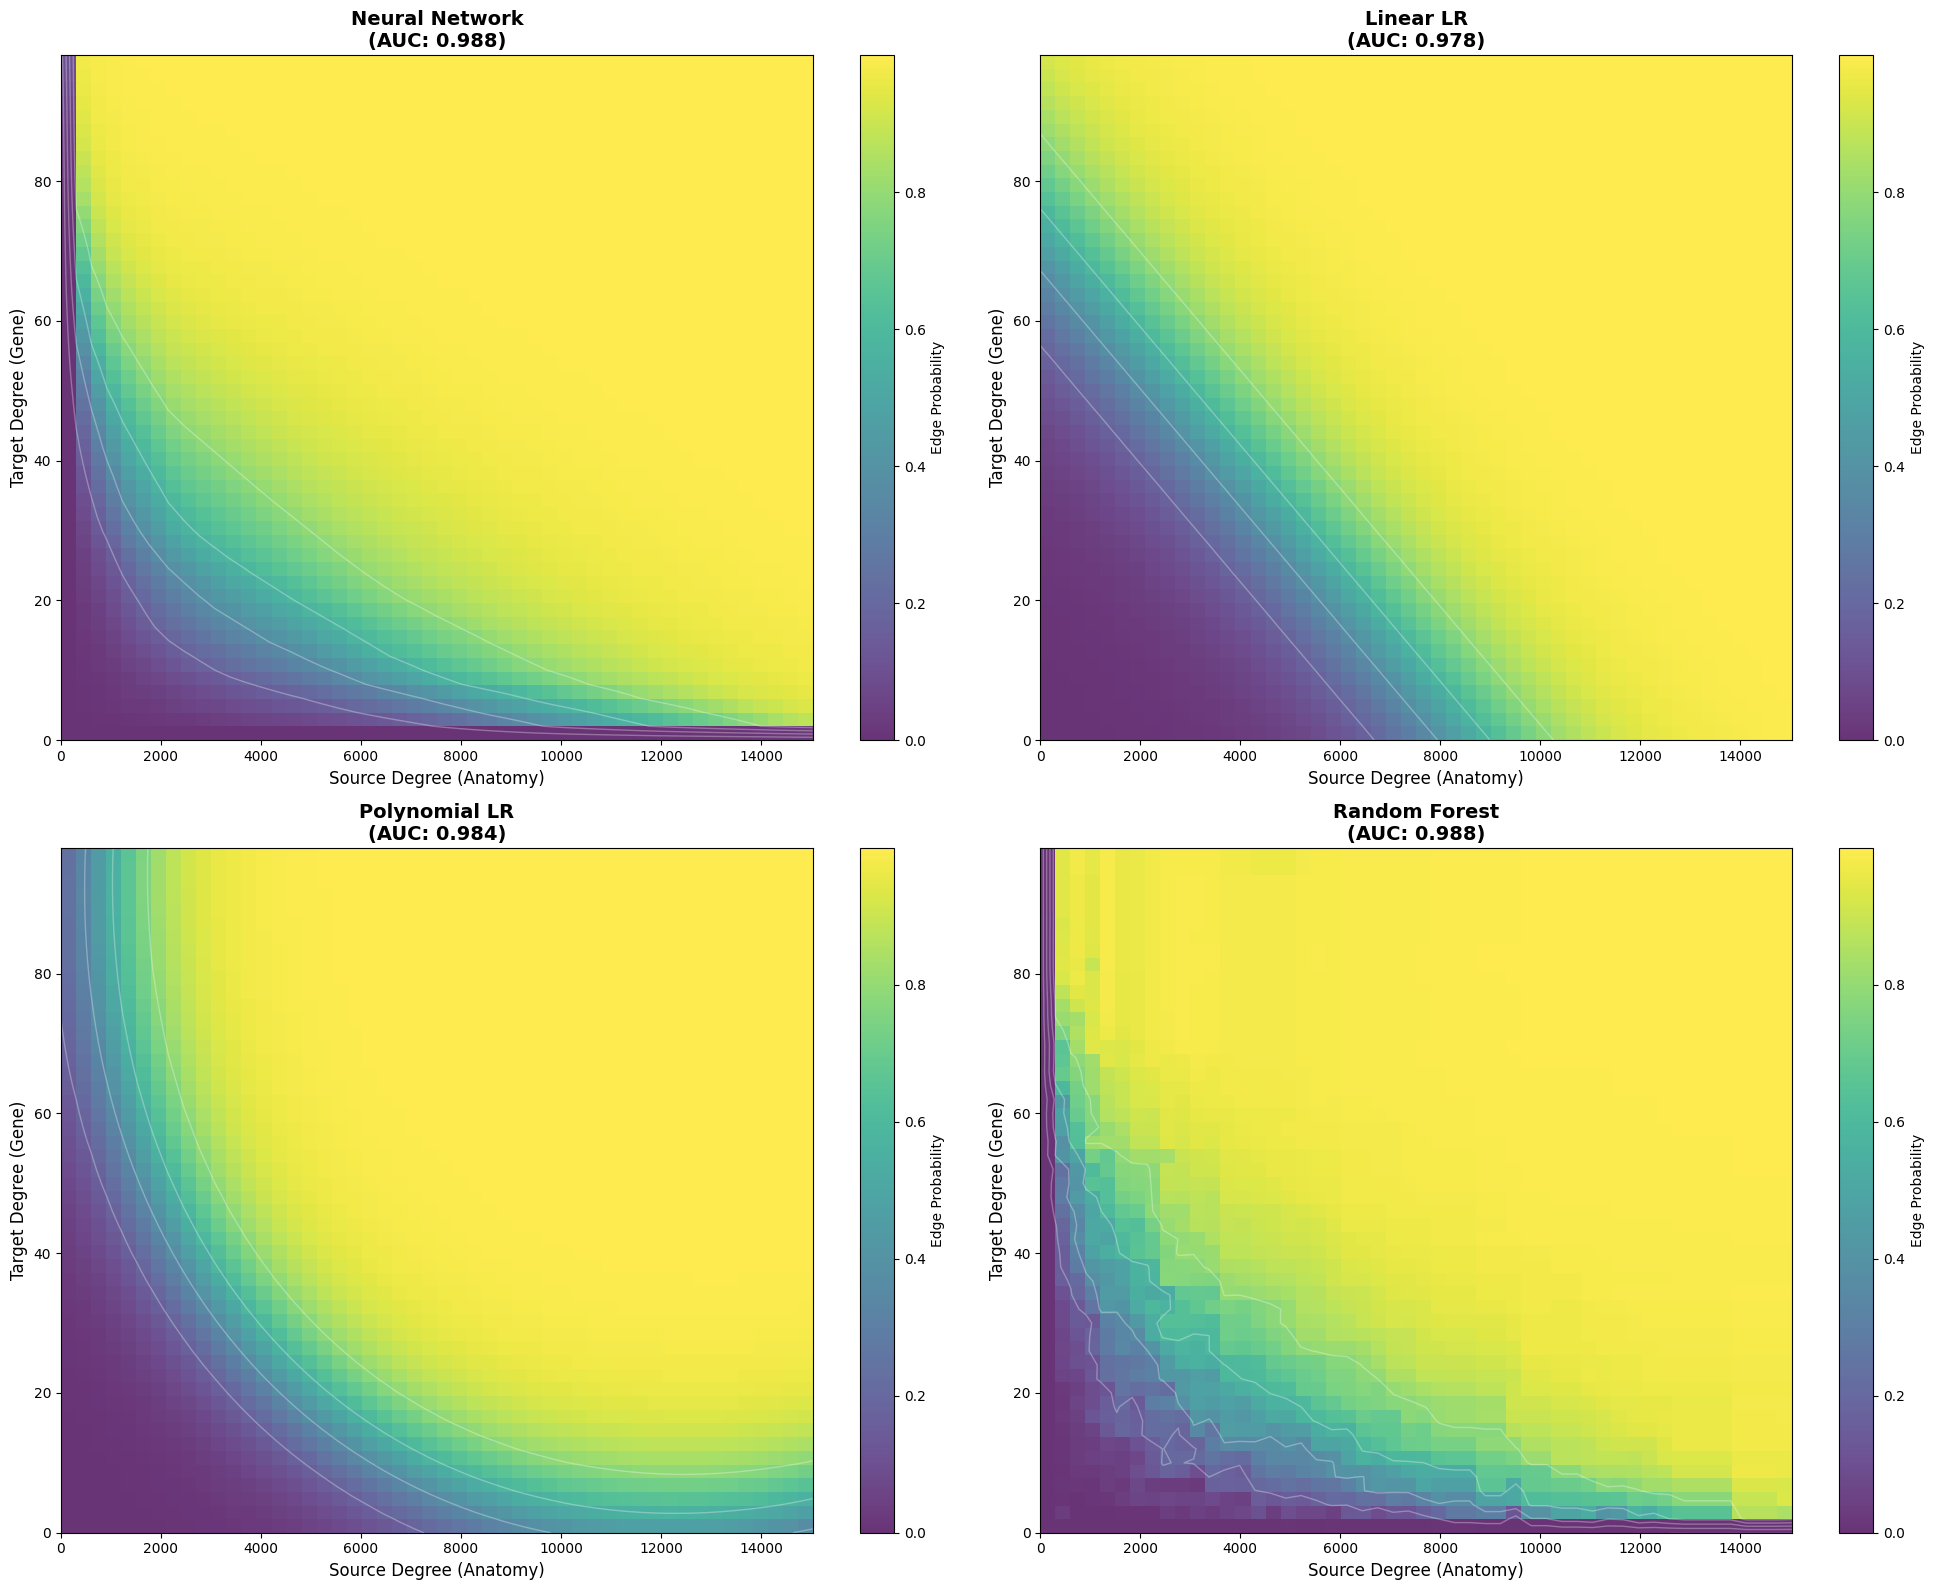


PROBABILITY DIFFERENCE HEATMAPS (vs Neural Network)

Linear LR vs Neural Network:
  Mean difference: -0.0430
  Max absolute difference: 0.9789
  Std difference: 0.1684

Polynomial LR vs Neural Network:
  Mean difference: -0.0467
  Max absolute difference: 0.6402
  Std difference: 0.1249

Random Forest vs Neural Network:
  Mean difference: -0.0034
  Max absolute difference: 0.2679
  Std difference: 0.0211


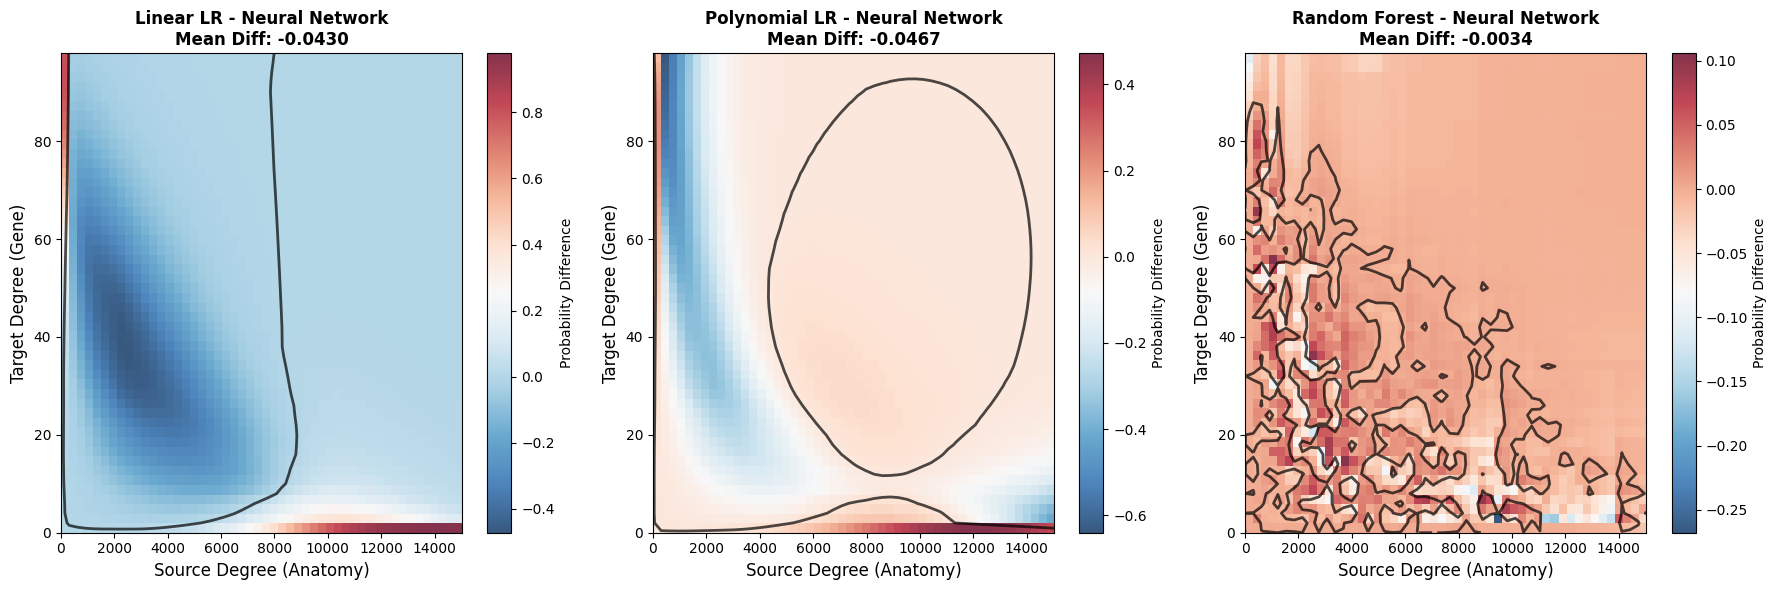


HEATMAP PATTERN ANALYSIS

Neural Network:
  Highest probability region:
    Source degree: 15036.0
    Target degree: 98.0
    Probability: 1.0000
  Lowest probability region:
    Source degree: 0.0
    Target degree: 0.0
    Probability: 0.0000

Linear LR:
  Highest probability region:
    Source degree: 15036.0
    Target degree: 98.0
    Probability: 1.0000
  Lowest probability region:
    Source degree: 0.0
    Target degree: 0.0
    Probability: 0.0014

Polynomial LR:
  Highest probability region:
    Source degree: 15036.0
    Target degree: 98.0
    Probability: 1.0000
  Lowest probability region:
    Source degree: 0.0
    Target degree: 0.0
    Probability: 0.0004

Random Forest:
  Highest probability region:
    Source degree: 14115.4
    Target degree: 82.0
    Probability: 0.9989
  Lowest probability region:
    Source degree: 9512.6
    Target degree: 0.0
    Probability: 0.0000

MODEL CORRELATION ANALYSIS


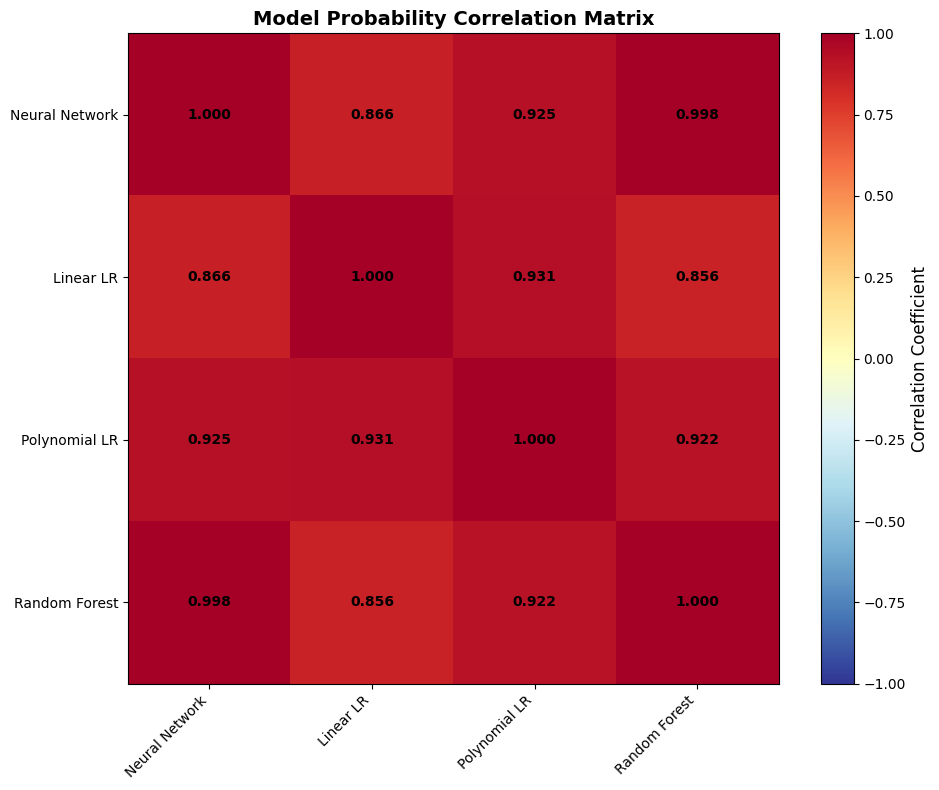


Correlation Insights:
Perfect correlation (1.0) indicates identical probability predictions
High correlation (>0.9) suggests similar decision boundaries
Low correlation (<0.7) indicates fundamentally different approaches
  Neural Network ↔ Random Forest: Very high similarity (0.998)

SUMMARY
The heatmaps reveal how each model predicts edge probabilities across
different source-target degree combinations. Key observations:
1. Similar patterns suggest linear relationships dominate
2. Different patterns indicate non-linear effects captured by complex models
3. Difference maps show where models disagree most
4. High correlation suggests the degree-based features are strong predictors


In [64]:
# Create probability heatmaps for all models comparison
print("\n" + "="*60)
print("PROBABILITY HEATMAPS COMPARISON - ALL MODELS")
print("="*60)

# Define degree ranges for heatmap
source_degrees_hm = np.linspace(
    combined_features[:, 0].min(), 
    combined_features[:, 0].max(), 
    50  # Lower resolution for faster computation
)
target_degrees_hm = np.linspace(
    combined_features[:, 1].min(), 
    combined_features[:, 1].max(), 
    50
)

print(f"Creating heatmaps with resolution 50x50...")
print(f"Source degree range: {source_degrees_hm.min():.1f} - {source_degrees_hm.max():.1f}")
print(f"Target degree range: {target_degrees_hm.min():.1f} - {target_degrees_hm.max():.1f}")

# Create meshgrid for all models
source_mesh, target_mesh = np.meshgrid(source_degrees_hm, target_degrees_hm)
features_grid = np.column_stack([source_mesh.flatten(), target_mesh.flatten()])

# Store probability matrices for all models
probability_matrices = {}

print("\nGenerating probability predictions for each model...")

# 1. Neural Network
print("1. Neural Network...")
nn_probability_matrix, _, _ = create_probability_heatmap(
    model, test_metrics['scaler'], source_degrees_hm, target_degrees_hm, resolution=50
)
probability_matrices['Neural Network'] = nn_probability_matrix

# 2. Linear Logistic Regression
print("2. Linear Logistic Regression...")
lr_features_scaled = scaler_comp.transform(features_grid)
lr_probabilities = model_results['Linear LR']['model'].predict_proba(lr_features_scaled)[:, 1]
probability_matrices['Linear LR'] = lr_probabilities.reshape(50, 50)

# 3. Polynomial Logistic Regression
print("3. Polynomial Logistic Regression...")
poly_features_grid = model_results['Polynomial LR']['poly_features'].transform(lr_features_scaled)
poly_probabilities = model_results['Polynomial LR']['model'].predict_proba(poly_features_grid)[:, 1]
probability_matrices['Polynomial LR'] = poly_probabilities.reshape(50, 50)

# 4. Random Forest
print("4. Random Forest...")
rf_probabilities = model_results['Random Forest']['model'].predict_proba(features_grid)[:, 1]
probability_matrices['Random Forest'] = rf_probabilities.reshape(50, 50)

# Create comprehensive heatmap visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Model names and positions
models = ['Neural Network', 'Linear LR', 'Polynomial LR', 'Random Forest']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Find global min/max for consistent color scale
all_probs = np.concatenate([prob_matrix.flatten() for prob_matrix in probability_matrices.values()])
vmin, vmax = all_probs.min(), all_probs.max()

print(f"\nGlobal probability range: {vmin:.4f} - {vmax:.4f}")

# Create heatmaps
extent = [source_degrees_hm.min(), source_degrees_hm.max(), 
          target_degrees_hm.min(), target_degrees_hm.max()]

for i, (model_name, (row, col)) in enumerate(zip(models, positions)):
    prob_matrix = probability_matrices[model_name]
    
    # Create heatmap
    im = axes[row, col].imshow(prob_matrix, 
                              extent=extent,
                              origin='lower', 
                              aspect='auto', 
                              cmap='viridis', 
                              vmin=vmin, 
                              vmax=vmax,
                              alpha=0.8)
    
    # Labels and title
    axes[row, col].set_xlabel('Source Degree (Anatomy)', fontsize=12)
    axes[row, col].set_ylabel('Target Degree (Gene)', fontsize=12)
    axes[row, col].set_title(f'{model_name}\n(AUC: {model_results[model_name]["auc"]:.3f})', 
                           fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[row, col])
    cbar.set_label('Edge Probability', fontsize=10)
    
    # Add contour lines for better visualization
    contour_levels = np.linspace(vmin, vmax, 6)
    contours = axes[row, col].contour(source_degrees_hm, target_degrees_hm, prob_matrix, 
                                    levels=contour_levels, colors='white', alpha=0.3, linewidths=1)
    
    # Print statistics for this model
    print(f"\n{model_name} Statistics:")
    print(f"  Probability range: {prob_matrix.min():.4f} - {prob_matrix.max():.4f}")
    print(f"  Mean probability: {prob_matrix.mean():.4f} ± {prob_matrix.std():.4f}")

plt.tight_layout()
plt.show()

# Create difference heatmaps (comparing to Neural Network)
print("\n" + "="*60)
print("PROBABILITY DIFFERENCE HEATMAPS (vs Neural Network)")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Compare other models to Neural Network
comparison_models = ['Linear LR', 'Polynomial LR', 'Random Forest']
nn_matrix = probability_matrices['Neural Network']

for i, model_name in enumerate(comparison_models):
    # Calculate difference (Other Model - Neural Network)
    diff_matrix = probability_matrices[model_name] - nn_matrix
    
    # Create difference heatmap
    im = axes[i].imshow(diff_matrix, 
                       extent=extent,
                       origin='lower', 
                       aspect='auto', 
                       cmap='RdBu_r',  # Red-Blue colormap for differences
                       alpha=0.8)
    
    axes[i].set_xlabel('Source Degree (Anatomy)', fontsize=12)
    axes[i].set_ylabel('Target Degree (Gene)', fontsize=12)
    axes[i].set_title(f'{model_name} - Neural Network\n'
                     f'Mean Diff: {diff_matrix.mean():+.4f}', 
                     fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i])
    cbar.set_label('Probability Difference', fontsize=10)
    
    # Add contour lines at zero difference
    axes[i].contour(source_degrees_hm, target_degrees_hm, diff_matrix, 
                   levels=[0], colors='black', linewidths=2, alpha=0.7)
    
    # Print difference statistics
    print(f"\n{model_name} vs Neural Network:")
    print(f"  Mean difference: {diff_matrix.mean():+.4f}")
    print(f"  Max absolute difference: {np.abs(diff_matrix).max():.4f}")
    print(f"  Std difference: {diff_matrix.std():.4f}")

plt.tight_layout()
plt.show()

# Analyze patterns in the heatmaps
print("\n" + "="*60)
print("HEATMAP PATTERN ANALYSIS")
print("="*60)

# Find regions of highest and lowest probabilities for each model
for model_name, prob_matrix in probability_matrices.items():
    print(f"\n{model_name}:")
    
    # High probability regions
    high_prob_threshold = np.percentile(prob_matrix, 95)
    high_prob_indices = np.unravel_index(np.argmax(prob_matrix), prob_matrix.shape)
    max_source_idx, max_target_idx = high_prob_indices[1], high_prob_indices[0]
    
    print(f"  Highest probability region:")
    print(f"    Source degree: {source_degrees_hm[max_source_idx]:.1f}")
    print(f"    Target degree: {target_degrees_hm[max_target_idx]:.1f}")
    print(f"    Probability: {prob_matrix.max():.4f}")
    
    # Low probability regions
    low_prob_indices = np.unravel_index(np.argmin(prob_matrix), prob_matrix.shape)
    min_source_idx, min_target_idx = low_prob_indices[1], low_prob_indices[0]
    
    print(f"  Lowest probability region:")
    print(f"    Source degree: {source_degrees_hm[min_source_idx]:.1f}")
    print(f"    Target degree: {target_degrees_hm[min_target_idx]:.1f}")
    print(f"    Probability: {prob_matrix.min():.4f}")

# Correlation analysis between models
print(f"\n" + "="*50)
print("MODEL CORRELATION ANALYSIS")
print("="*50)

model_names_corr = list(probability_matrices.keys())
correlation_matrix = np.zeros((len(model_names_corr), len(model_names_corr)))

for i, model1 in enumerate(model_names_corr):
    for j, model2 in enumerate(model_names_corr):
        correlation = np.corrcoef(
            probability_matrices[model1].flatten(),
            probability_matrices[model2].flatten()
        )[0, 1]
        correlation_matrix[i, j] = correlation

# Plot correlation matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)

# Add correlation values as text
for i in range(len(model_names_corr)):
    for j in range(len(model_names_corr)):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_xticks(range(len(model_names_corr)))
ax.set_yticks(range(len(model_names_corr)))
ax.set_xticklabels(model_names_corr, rotation=45, ha='right')
ax.set_yticklabels(model_names_corr)
ax.set_title('Model Probability Correlation Matrix', fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient', fontsize=12)

plt.tight_layout()
plt.show()

# Print correlation insights
print(f"\nCorrelation Insights:")
print(f"Perfect correlation (1.0) indicates identical probability predictions")
print(f"High correlation (>0.9) suggests similar decision boundaries")
print(f"Low correlation (<0.7) indicates fundamentally different approaches")

for i, model1 in enumerate(model_names_corr):
    for j, model2 in enumerate(model_names_corr):
        if i < j:  # Only print upper triangle
            corr_val = correlation_matrix[i, j]
            if corr_val > 0.95:
                print(f"  {model1} ↔ {model2}: Very high similarity ({corr_val:.3f})")
            elif corr_val < 0.8:
                print(f"  {model1} ↔ {model2}: Significant differences ({corr_val:.3f})")

print(f"\n" + "="*60)
print("SUMMARY")
print("="*60)
print("The heatmaps reveal how each model predicts edge probabilities across")
print("different source-target degree combinations. Key observations:")
print("1. Similar patterns suggest linear relationships dominate")
print("2. Different patterns indicate non-linear effects captured by complex models")
print("3. Difference maps show where models disagree most")
print("4. High correlation suggests the degree-based features are strong predictors")